In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
URL = 'file:///content/drive/MyDrive/x-ray_dataset.zip'
PATH = tf.keras.utils.get_file('x-ray_dataset.zip', origin=URL, extract=True)
PATH = os.path.join(os.path.dirname(PATH), 'x-ray_dataset')
TRAIN_DIR = os.path.join(PATH, 'train')
VALIDATION_DIR = os.path.join(PATH, 'validation')

BATCH_SIZE = 64
IMG_SIZE = (160, 160)

In [ ]:
train_dataset = image_dataset_from_directory(TRAIN_DIR,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(VALIDATION_DIR,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2290 files belonging to 2 classes.
Found 572 files belonging to 2 classes.


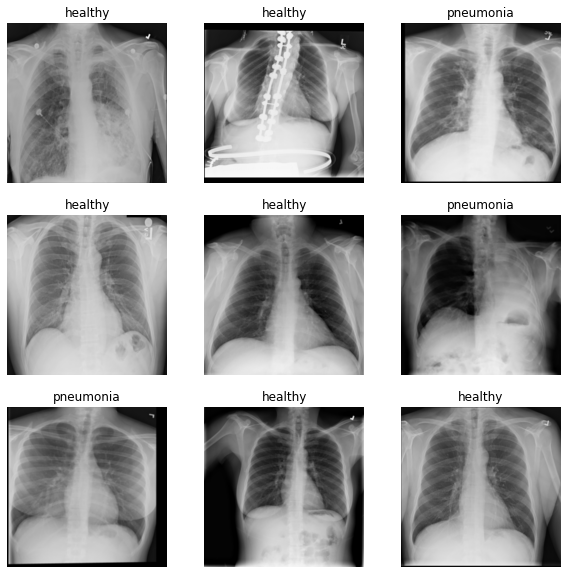

In [ ]:
classes = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal')
])

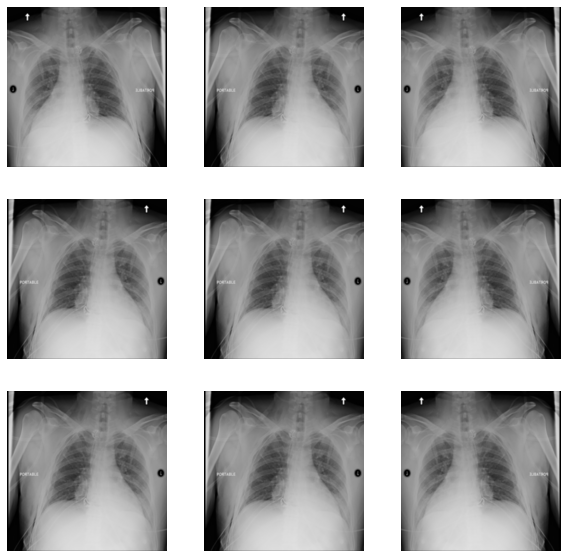

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.densenet.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 5, 5, 1920)


In [ ]:
base_model.trainable = False
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 166, 166, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 80, 80, 64)   9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1920)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_6 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.nn.bias_add_3 (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_7 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 5, 5, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1920)              0   

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

8/8 [==============================] - 6s 62ms/step - loss: 0.7615 - accuracy: 0.5026


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.75
initial accuracy: 0.53


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
36/36 [==============================] - 15s 117ms/step - loss: 0.7807 - accuracy: 0.5079 - val_loss: 0.7251 - val_accuracy: 0.5453
Epoch 2/10
36/36 [==============================] - 5s 115ms/step - loss: 0.7671 - accuracy: 0.5096 - val_loss: 0.6915 - val_accuracy: 0.5906
Epoch 3/10
36/36 [==============================] - 5s 114ms/step - loss: 0.7310 - accuracy: 0.5502 - val_loss: 0.6896 - val_accuracy: 0.5886
Epoch 4/10
36/36 [==============================] - 5s 113ms/step - loss: 0.7360 - accuracy: 0.5563 - val_loss: 0.6699 - val_accuracy: 0.5984
Epoch 5/10
36/36 [==============================] - 5s 112ms/step - loss: 0.7139 - accuracy: 0.5782 - val_loss: 0.6540 - val_accuracy: 0.6102
Epoch 6/10
36/36 [==============================] - 5s 114ms/step - loss: 0.6944 - accuracy: 0.5755 - val_loss: 0.6551 - val_accuracy: 0.6004
Epoch 7/10
36/36 [==============================] - 4s 111ms/step - loss: 0.6867 - accuracy: 0.5873 - val_loss: 0.6444 - val_accuracy: 0.6122
Epoch

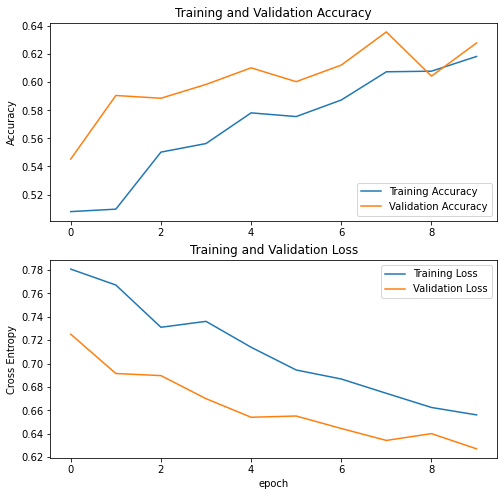

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  707


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_6 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.nn.bias_add_3 (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_7 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 5, 5, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1920)              0   

In [ ]:
len(model.trainable_variables)

521

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
36/36 [==============================] - 43s 318ms/step - loss: 0.6873 - accuracy: 0.6269 - val_loss: 0.5566 - val_accuracy: 0.7146
Epoch 11/20
36/36 [==============================] - 9s 223ms/step - loss: 0.5178 - accuracy: 0.7323 - val_loss: 0.5111 - val_accuracy: 0.6949
Epoch 12/20
36/36 [==============================] - 9s 223ms/step - loss: 0.4575 - accuracy: 0.7653 - val_loss: 0.4593 - val_accuracy: 0.7283
Epoch 13/20
36/36 [==============================] - 9s 223ms/step - loss: 0.4100 - accuracy: 0.8017 - val_loss: 0.4307 - val_accuracy: 0.7303
Epoch 14/20
36/36 [==============================] - 9s 223ms/step - loss: 0.3596 - accuracy: 0.8372 - val_loss: 0.3693 - val_accuracy: 0.8465
Epoch 15/20
36/36 [==============================] - 9s 222ms/step - loss: 0.3296 - accuracy: 0.8543 - val_loss: 0.7490 - val_accuracy: 0.6358
Epoch 16/20
36/36 [==============================] - 9s 224ms/step - loss: 0.3471 - accuracy: 0.8419 - val_loss: 0.3866 - val_accuracy: 0.856

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

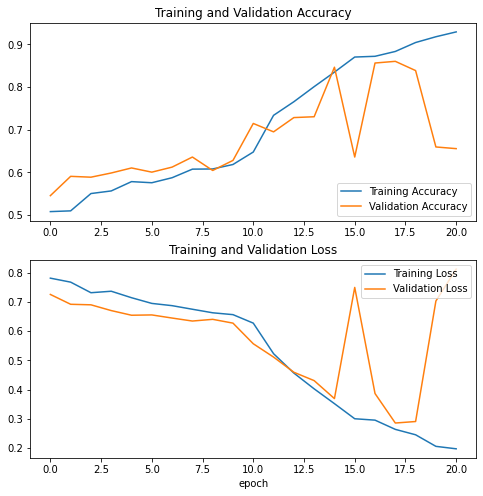

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 712ms/step - loss: 0.8150 - accuracy: 0.6562
Test accuracy : 0.65625


Predictions:
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0
 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0]
Labels:
 [0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0
 1 0 0 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1]


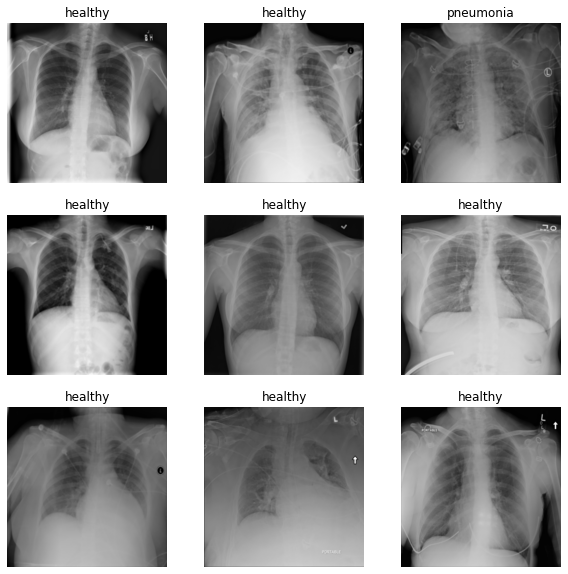

In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(classes[predictions[i]])
  plt.axis("off")